<a href="https://colab.research.google.com/github/kzw333/GEO5990-final/blob/main/geog5990m_final_project_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5990M Final Assignment (Template)

Student ID number:

##Exploring the Relationship Between House Age and Property Prices in Leeds(1995–2020)


Housing affordability and urban transformation are pressing challenges faced by many UK cities, including Leeds. Understanding the relationship between building age and house prices can provide valuable insights for urban renewal strategies, real estate investment decisions, and housing equity analyses. Older properties may have historical value or structural challenges, while newer properties often reflect recent development trends and planning policies.

This project aims to analyze the spatial and temporal patterns of house prices in Leeds over six key years (1995, 2000, 2005, 2010, 2015, and 2020) and explore their relationship with building age. The key questions addressed are: Do house prices vary significantly based on the age of the property at different time points? How have these relationships changed over time in the context of urban development?

The data used in this study primarily comes from the Valuation Office Agency (VOA) and the Land Registry, provided by the Consumer Data Research Centre (CDRC). By combining spatial boundary data, property price records, and building age classifications, this study seeks to uncover trends and spatial differences in housing values related to construction periods.

The final outcomes are designed to support urban planners, policymakers, and the general public by providing spatial and non-spatial visualizations of the data. Spatial analysis focuses on the distribution of house prices in Leeds in relation to building age, while non-spatial analysis illustrates the average price trends by property age group, providing actionable insights for housing development and urban regeneration decisions..


In [23]:
# read in required packages
# import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import any further required packages
# Install the contextily library (for adding map basemaps like OpenStreetMap)
# Install the geoplot library (for advanced geographical data visualizations, like choropleth maps, density plots, etc.)
# Install the geo_northarrow library from GitHub (for adding a north arrow to maps
!pip install contextily
!pip install geoplot
!pip install git+https://github.com/pmdscully/geo_northarrow.git
import pyproj
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
from geo_northarrow import add_north_arrow
import matplotlib.patches as patches
import geopandas as gpd


  Cloning https://github.com/pmdscully/geo_northarrow.git to /tmp/pip-req-build-u3h_sbb4
  Running command git clone --filter=blob:none --quiet https://github.com/pmdscully/geo_northarrow.git /tmp/pip-req-build-u3h_sbb4
  Resolved https://github.com/pmdscully/geo_northarrow.git to commit 963bdd271707a3bcaa47b2d83d92b88ae0b10950
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



## 1. Data Loading

This project uses four openly available datasets covering housing prices, building age, and geographic boundaries within Leeds:

- **VOA Property Age Data**  
  Source: Valuation Office Agency (VOA). This dataset provides the proportion of residential buildings by construction period within each LSOA. It is used to estimate the distribution of housing age across Leeds.

- **Median House Prices (Quarterly, 1995–2018)**  
  Source: CDRC / HM Land Registry. This dataset contains median house prices by quarter and by LSOA between 1995 Q1 and 2018 Q4, enabling temporal analysis of housing price trends.

- **Average House Prices in 2020–2021**  
  Source: CDRC / HM Land Registry..  
  This dataset provides average house prices by LSOA for Q1 2020 and Q2 2021. Values are averaged over 12 months including the quarter. The dataset is used in the CDRC Mapmaker and is suitable for spatial comparison of recent house prices.


- **Leeds Boundary GeoJSON**  
  Source: OpenStreetMap (OSM). A GeoJSON file containing the boundaries of LSOAs within the Leeds metropolitan area, required for mapping and spatial analysis.

Data was loaded using `pandas` and `geopandas`:



In [24]:
1.#load data
voa_property_age_data = pd.read_csv('https://github.com/kzw333/GEO5990-final/raw/refs/heads/main/voapropertyage.csv')
price_data = pd.read_csv('https://github.com/kzw333/GEO5990-final/raw/refs/heads/main/Median_Prices_Quarterly.csv')
price_data_2020=pd.read_csv('https://github.com/kzw333/GEO5990-final/raw/refs/heads/main/hpssa202103.csv')
leeds=gpd.read_file('https://github.com/kzw333/GEO5990-final/raw/refs/heads/main/Leeds.geojson')


## 2.Data Preprocessing
- **Data Exploration**

  Inspect the structure and missing values of property age and price datasets.

  Check the spatial data structure and CRS of the Leeds boundary.

  Use the explore() method for a quick spatial visualization of the Leeds boundary.

- **Data Cleaning**

  Drop rows with missing values in the lsoa_cd column.
  The lsoa_cd column has one missing value, and deleting this row will typically not significantly affect the representativeness of the overall dataset.

  Fill missing values in the price dataset using the median for each column to ensure completeness.
  Median, as a robust statistical measure, is a common and effective method for imputing missing values.

- **Data Merging**

  Merge property age data with historical price data based on lsoa_cd.

  Add the 2020 price data.

  Merge with the Leeds boundary data to create the final spatial analysis dataset df_final



In [25]:
2.#Data Exploration
#View the data structure
voa_property_age_data.head()
price_data.head()
voa_property_age_data.info()
# Check for missing values
voa_property_age_data.isnull().sum()
price_data.isnull().sum()
print(price_data['lsoa_cd'].isnull().sum())

# let's have a look at the Leeds geopandas dataframe
leeds.head()
leeds.info()
leeds.isnull().sum()
# Check the CRS
print(leeds.crs)
#Use the explore() method from geopandas to create an interactive map, quickly visualizing the spatial data in the leeds GeoDataFrame
leeds.explore()

# 3. Data Cleaning
# Drop rows with missing values in the 'lsoa_cd' column.
price_data = price_data.dropna(subset=['lsoa_cd'])
# Display the result after dropping rows
print(price_data)
print(price_data['lsoa_cd'].isnull().sum())

# Fill missing values using the median
price_data.iloc[:, 2:] = price_data.iloc[:, 2:].apply(lambda row: row.fillna(row.median()), axis=0)
print(price_data)
price_data.isnull().sum()

# 4. Data Merging
# Merge the VOAs property age data with the price data on 'AREA_CODE' and 'lsoa_cd'.
df = pd.merge(voa_property_age_data, price_data, left_on='AREA_CODE', right_on='lsoa_cd', how='left')

# Merge the merged data with price data for 2020 on 'AREA_CODE' and 'lsoacode'.
df_1 = pd.merge(df, price_data_2020, left_on='AREA_CODE', right_on='lsoacode', how='left')

# Merge the final dataframe with Leeds data on 'LSOA21CD' and 'lsoacode'.
df_final = pd.merge(leeds, df_1, left_on='LSOA21CD', right_on='lsoacode', how='left')

# Check the result of the first merge
print(df.head())
# Check the result of the second merge
print(df_1.head())
# Check the result of the third merge
print(df_final.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AREA_CODE          34753 non-null  object 
 1   AREA_NAME          34753 non-null  object 
 2   BP_PRE_1900        34753 non-null  int64  
 3   BP_1900_1918       34753 non-null  int64  
 4   BP_1919_1929       34753 non-null  int64  
 5   BP_1930_1939       34753 non-null  int64  
 6   BP_1945_1954       34753 non-null  int64  
 7   BP_1955_1964       34753 non-null  int64  
 8   BP_1965_1972       34753 non-null  int64  
 9   BP_1973_1982       34753 non-null  int64  
 10  BP_1983_1992       34753 non-null  int64  
 11  BP_1993_1999       34753 non-null  int64  
 12  BP_2000_2009       34753 non-null  int64  
 13  BP_2010_2015       34753 non-null  int64  
 14  BP_UNKNOWN         34753 non-null  int64  
 15  ALL_PROPERTIES     34753 non-null  int64  
 16  MODE1_VAL          347

# **Non-spatial visualization map data preparation**
- **Construction of Annual Price Indicators**

 Create annual price indicators for subsequent time series analysis or trend comparison; simplify the data so that each year only uses one representative indicator.

- **Aggregation**

 ***df.groupby('column').agg('aggregation')***:Used to group data by specific columns and apply one or more summary statistics (such as sum, mean, count) to each group.

 Group the property data by MODE1_TYPE, which represents the building age types (e.g., "Built before 1900", "Built between 1990–1999", etc.). Then, calculate the following for each building age type:

 **total_properties_mode1**:The total number of properties in this building age type.

 **avg_price_1995 to avg_price_2020**: The average property prices for this building age type in six key years (1995, 2000, 2005, 2010, 2015, 2020).

 This will allow to observe the distribution of properties across different building age types and their price trends over time.

 Another classification set (MODE2_TYPE) also reflects the building age but is sourced or defined slightly differently. In this case, only the number of properties for each building age type will be calculated, without repeating the calculation of property prices. This approach enhances the overall coverage of the data.

 **Merge statistics from MODE1 and MODE2**

 This merges the quantity and price data from both building age classifications into a single table for easier analysis and visualization. The outer merge retains all records, ensuring no information is lost, even if some building age types appear in only one dataset.

 **Define the logical order of building age types**

   ***pd.Categorical(..., ordered=True)***：This is a method in Pandas specifically used to handle "ordered categorical variables". It not only saves memory but also controls sorting, grouping, plotting, and other

   ***.sort_values()*** ：Sorting categorical variables

 Setting an ordered category ensures that visualizations (e.g., bar charts, line graphs) are arranged in chronological order, making the analysis more intuitive and logically organized.



In [26]:
#5 Construction of Annual Price Indicators
# Calculate average annual prices for selected years using quarterly median values
df_final["price_1995"] = df_final[["median_95Q1", "median_95Q2", "median_95Q3", "median_95Q4"]].mean(axis=1)
df_final["price_2000"] = df_final[["median_00Q1", "median_00Q2", "median_00Q3", "median_00Q4"]].mean(axis=1)
df_final["price_2005"] = df_final[["median_05Q1", "median_05Q2", "median_05Q3", "median_05Q4"]].mean(axis=1)
df_final["price_2010"] = df_final[["median_10Q1", "median_10Q2", "median_10Q3", "median_10Q4"]].mean(axis=1)
df_final["price_2015"] = df_final[["median_15Q1", "median_15Q2", "median_15Q3", "median_15Q4"]].mean(axis=1)
df_final["price_2020"] = df_final["hpmd202003"]

6.# Calculate summary statistics for MODE1, including average house prices in six selected years
mode1_stats = df_final.groupby('MODE1_TYPE').agg(
    total_properties_mode1=('MODE1_VAL', 'sum'),
    avg_price_1995=('price_1995', 'mean'),
    avg_price_2000=('price_2000', 'mean'),
    avg_price_2005=('price_2005', 'mean'),
    avg_price_2010=('price_2010', 'mean'),
    avg_price_2015=('price_2015', 'mean'),
    avg_price_2020=('price_2020', 'mean')
).reset_index().rename(columns={'MODE1_TYPE': 'Building_Age_Type'})

# Calculate total properties by building age type based on MODE2
mode2_stats = df_final.groupby('MODE2_TYPE').agg(
    total_properties_mode2=('MODE2_VAL', 'sum')
).reset_index().rename(columns={'MODE2_TYPE': 'Building_Age_Type'})
# Show results to check if the calculation is correct
print(mode1_stats.head())
print(mode2_stats.head())

# Merge statistics from MODE1 and MODE2
combined_stats = pd.merge(mode1_stats, mode2_stats, on='Building_Age_Type', how='outer')
# View the merged data
print(combined_stats.head())

# Define the logical order of building age types
building_age_order = [
    "BP_PRE_1900", "BP_1900_1918", "BP_1919_1929", "BP_1930_1939", "BP_1945_1954", "BP_1955_1964",
    "BP_1965_1972", "BP_1973_1982", "BP_1983_1992", "BP_1993_1999", "BP_2000_2009", "BP_2010_2015", "BP_UNKNOWN"
]

# Set Building_Age_Type as an ordered categorical variable and sort the final results
combined_stats['Building_Age_Type'] = pd.Categorical(
    combined_stats['Building_Age_Type'],
    categories=building_age_order,
    ordered=True
)

# Sort data
combined_stats = combined_stats.sort_values('Building_Age_Type')

# View the sorted data
print(combined_stats.head())





  Building_Age_Type  total_properties_mode1  avg_price_1995  avg_price_2000  \
0      BP_1900_1918                  7980.0    32317.019737    36429.276316   
1      BP_1919_1929                  5550.0    39456.541667    53896.729167   
2      BP_1930_1939                 29330.0    52808.716398    69100.262097   
3      BP_1945_1954                  9590.0    45759.553571    54473.727679   
4      BP_1955_1964                 24060.0    59340.703704    76644.336420   

   avg_price_2005  avg_price_2010  avg_price_2015  avg_price_2020  
0    94174.736842   101312.269737    93822.085526   113735.944444  
1   104595.000000   115882.159722   122388.444444   156743.764706  
2   147250.096774   161183.520161   171462.822581   216414.186813  
3   121575.102679   129208.392857   132281.678571   175454.714286  
4   153216.861111   169219.416667   180585.944444   225363.100000  
  Building_Age_Type  total_properties_mode2
0      BP_1900_1918                  2470.0
1      BP_1919_1929          

# **Spatial visualization map data preparation**
- **Map Visualization Process and Exploration**

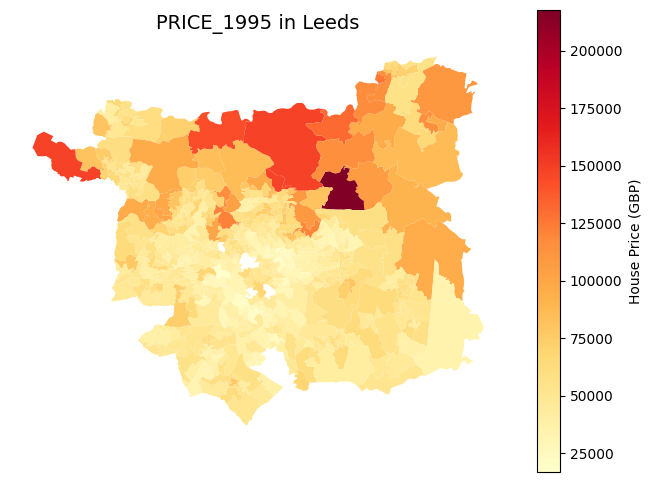

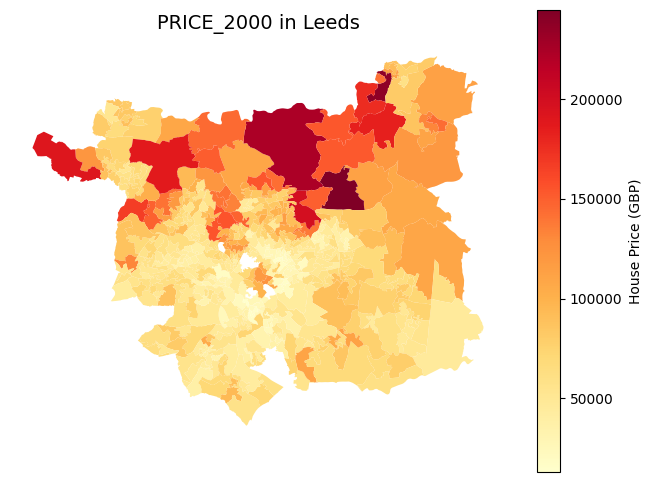

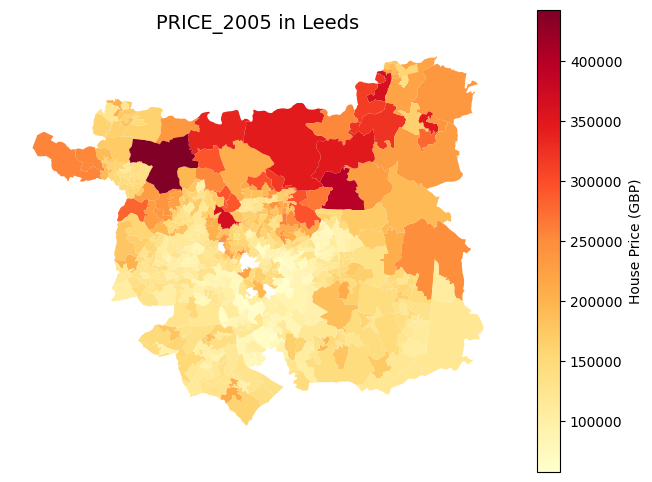

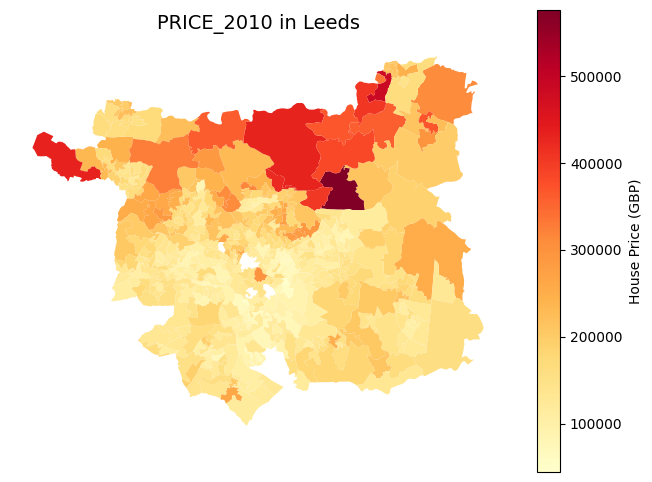

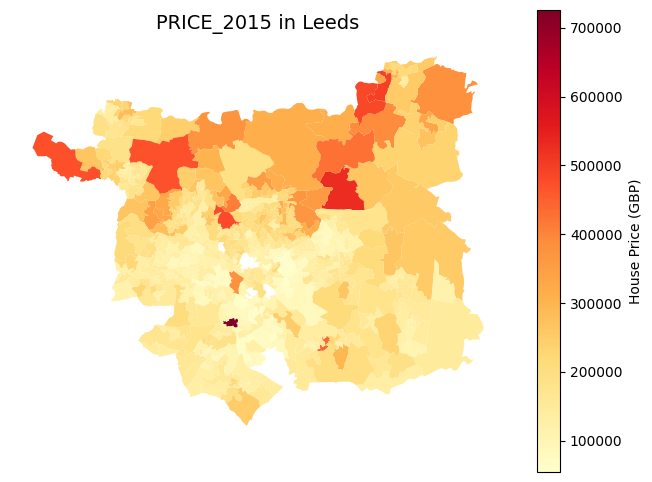

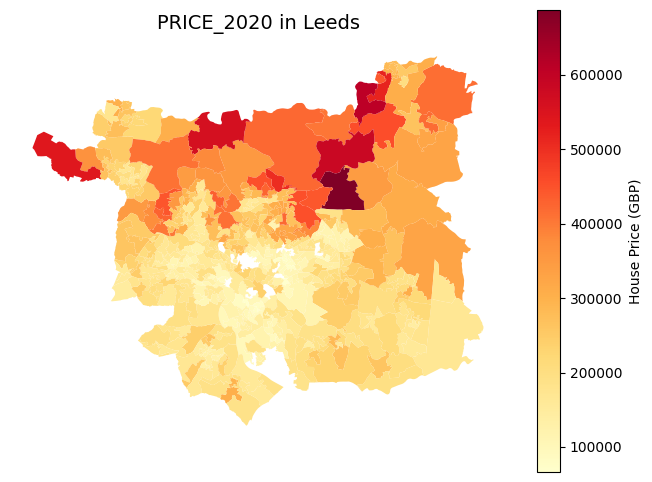

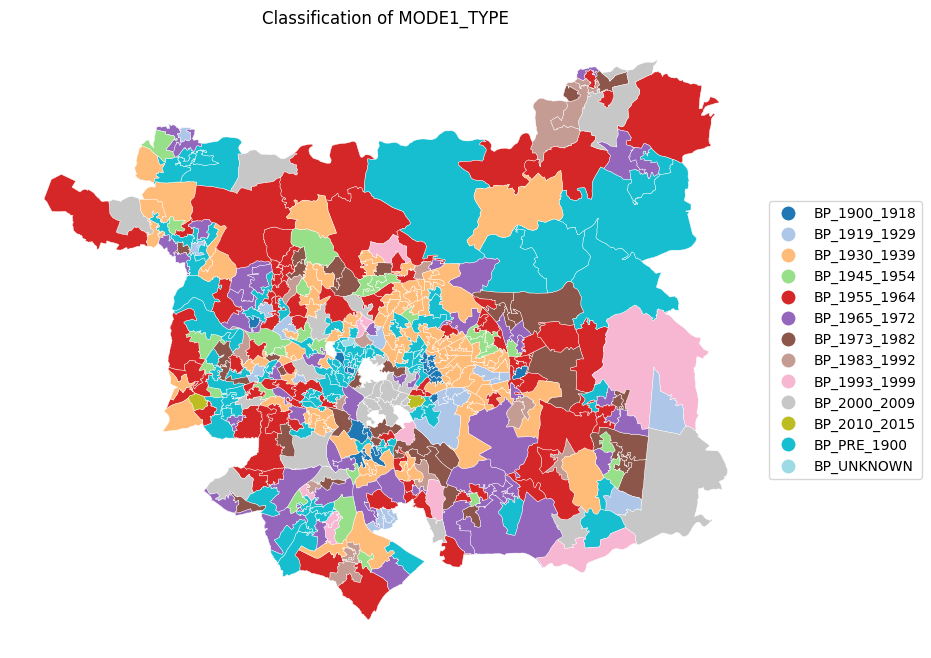

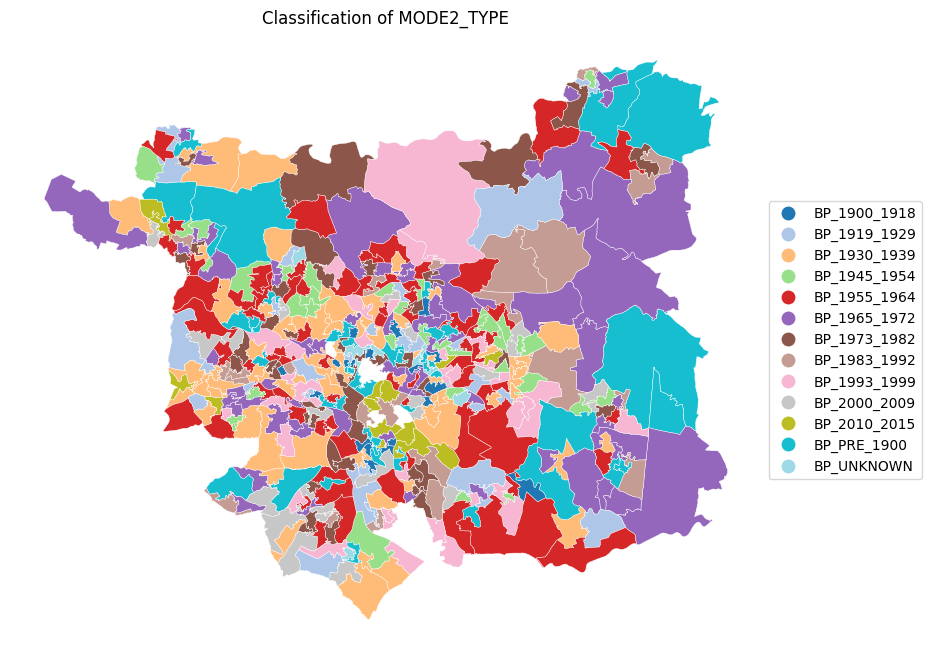

In [8]:

#Convert a regular DataFrame to a GeoDataFrame
df_final = gpd.GeoDataFrame(df_final, geometry='geometry')

#1.房价字段列表
price_cols = ['price_1995', 'price_2000', 'price_2005', 'price_2010', 'price_2015', 'price_2020']

# 批量绘图
for col in price_cols:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    df_final.plot(
        column=col,
        cmap='YlOrRd',
        linewidth=0.2,
        legend=True,
        ax=ax,
        legend_kwds={'label': 'House Price (GBP)', 'orientation': 'vertical'}
    )

    ax.set_title(f'{col.upper()} in Leeds', fontsize=14)
    ax.axis('off')
    plt.savefig(f'{col}_leeds_map.jpg', bbox_inches='tight')
    #plt.close()


# 2.绘制分类地图
f, ax = plt.subplots(1, figsize=(16, 8))

df_final.plot(
    column='MODE1_TYPE',  # 选择分类变量
    legend=True,          # 显示图例
    cmap='tab20',          # 分类颜色方案，可以尝试 'Set3' 或其他颜色方案
    edgecolor='white',    # 边界颜色
    linewidth=0.3,        # 边界线宽
    categorical=True,     # 重要：启用分类数据
    ax=ax,                # 设置坐标轴
    legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)}  # 设置图例位置
)

# 设置标题
ax.set_title('Classification of MODE1_TYPE')

# 隐藏坐标轴
ax.set_axis_off()

# 显示地图
plt.show()

f, ax = plt.subplots(1, figsize=(16, 8))
# 3.绘制分类地图
df_final.plot(
    column='MODE2_TYPE',  # 选择分类变量
    legend=True,          # 显示图例
    cmap='tab20',          # 分类颜色方案，可以尝试 'Set3' 或其他颜色方案
    edgecolor='white',    # 边界颜色
    linewidth=0.3,        # 边界线宽
    categorical=True,     # 重要：启用分类数据
    ax=ax,                # 设置坐标轴
    legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)}  # 设置图例位置
)

# 设置标题
ax.set_title('Classification of MODE2_TYPE')

# 隐藏坐标轴
ax.set_axis_off()

# 显示地图
plt.show()



     MODE1_TYPE House_Type
0  BP_1965_1972  Old House
1   BP_PRE_1900  Old House
2  BP_2000_2009  New House
3  BP_1945_1954  Old House
4  BP_1955_1964  Old House


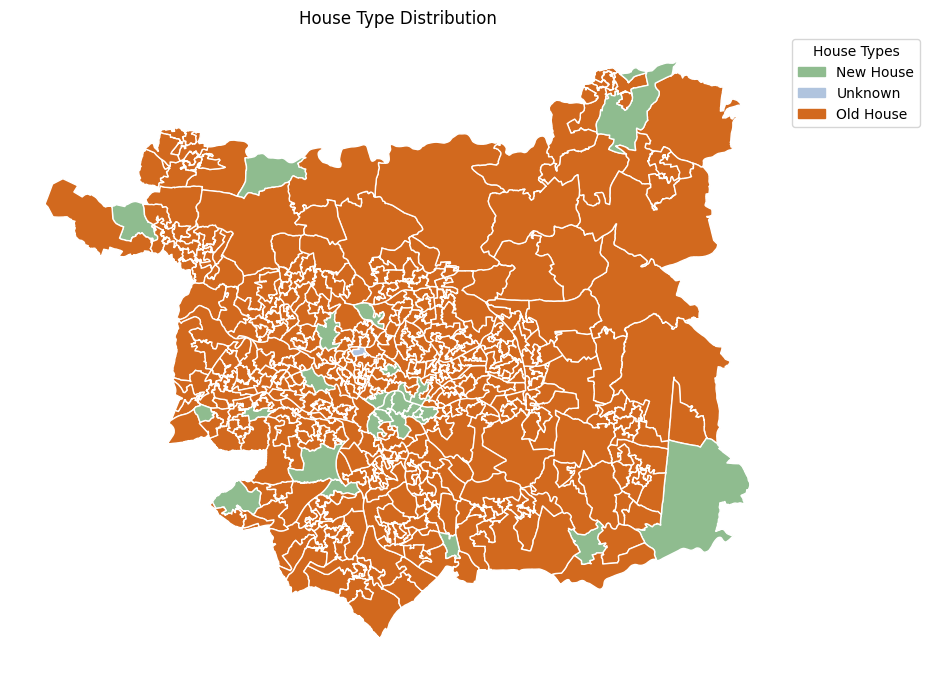

In [11]:


# 创建新的分类列 'House_Type'，默认值为 'Old House'
df_final['House_Type'] = 'Old House'

# 将 'MODE1_TYPE' 为 'BP_2000_2009' 或 'BP_2010_2015' 的行设为 'New House'
df_final.loc[df_final['MODE1_TYPE'].isin(['BP_2000_2009', 'BP_2010_2015']), 'House_Type'] = 'New House'

# 将 'MODE1_TYPE' 为 'BP_UNKNOWN' 的行设为 'Unknown'
df_final.loc[df_final['MODE1_TYPE'] == 'BP_UNKNOWN', 'House_Type'] = 'Unknown'

# 查看结果，只输出 'MODE1_TYPE' 和 'House_Type' 列
print(df_final[['MODE1_TYPE', 'House_Type']].head())


# 创建颜色映射
color_map = {
   "New House": "#8FBC8F",  # 绿色 - 软绿色
    "Unknown": "#B0C4DE",    # 浅灰蓝色 - 更现代的灰色
    "Old House": "#D2691E"   # 砖红色 - 温暖的红色
}

# 创建一个图
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 绘制地图
df_final.plot(ax=ax, color=df_final['House_Type'].map(color_map), edgecolor='white')

# 创建图例手动添加
handles = [patches.Patch(color=color_map['New House'], label='New House'),
           patches.Patch(color=color_map['Unknown'], label='Unknown'),
           patches.Patch(color=color_map['Old House'], label='Old House')]

# 添加图例，调整位置
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1), title="House Types")

# 设置标题
ax.set_title('House Type Distribution')

# 隐藏坐标轴
ax.set_axis_off()

# 显示地图
plt.show()


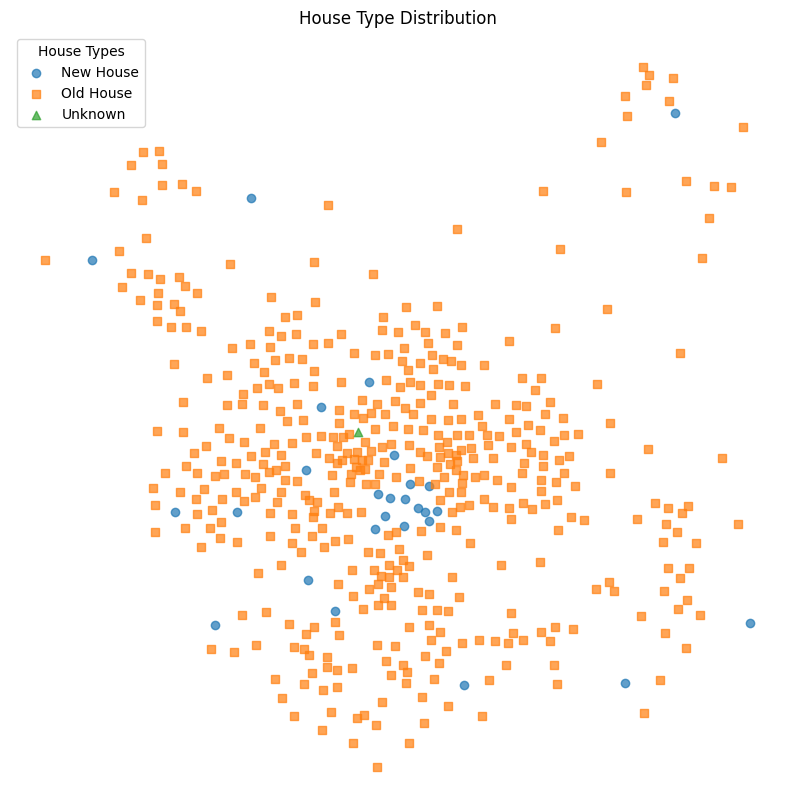

In [12]:


# 创建符号映射
symbol_map = {
    "New House": "o",  # 新房 - 圆形
    "Unknown": "^",    # 未知 - 三角形
    "Old House": "s"   # 老房 - 方形
}
# 假设 subset 是你的 GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# 如果你的数据是多边形，可以取其质心（center point）
for House_Type, marker in zip(['New House', 'Old House', 'Unknown'], ['o', 's', '^']):
    subset = df_final[df_final['House_Type'] == House_Type]  # 假设你已经根据房屋类型过滤了数据
    ax.scatter(subset.geometry.centroid.x, subset.geometry.centroid.y, marker=marker, label=House_Type, alpha=0.7)

# 设置标题
ax.set_title('House Type Distribution')

# 添加图例
ax.legend(title="House Types")
# 隐藏坐标轴
ax.set_axis_off()

# 显示地图
plt.show()

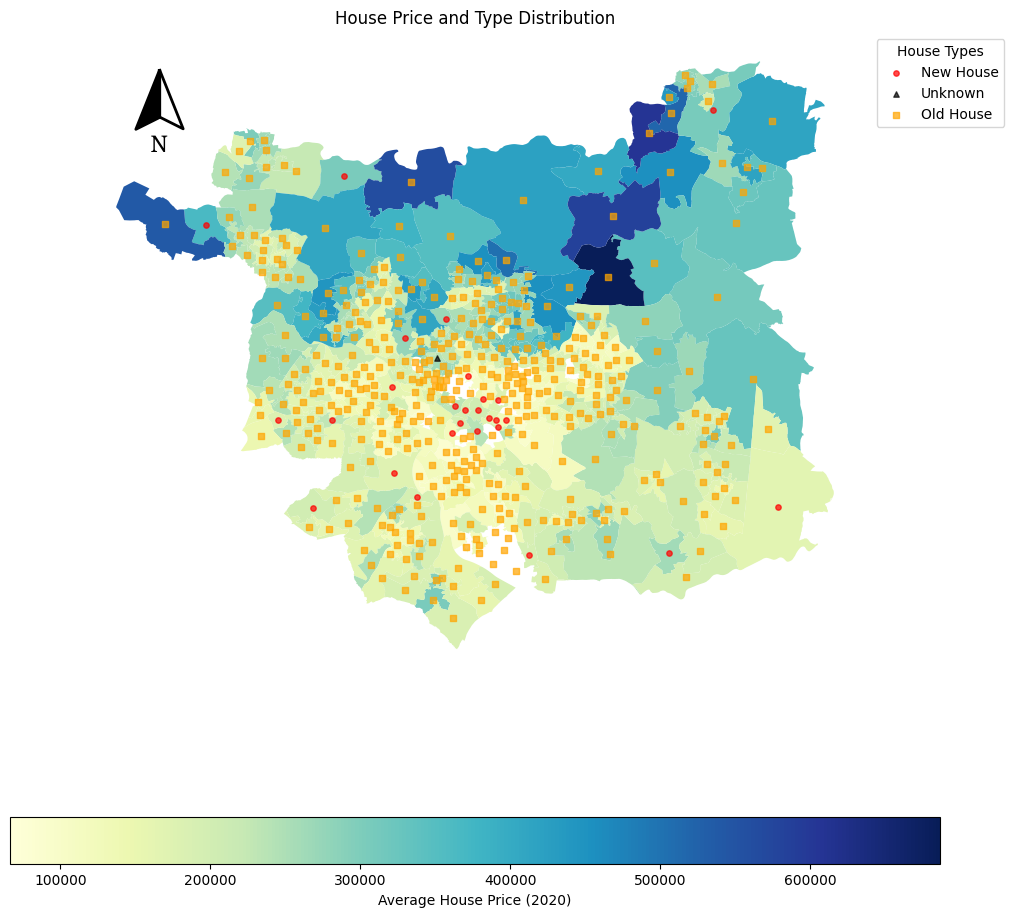

In [13]:
# 创建符号和颜色映射
symbol_map = {
    "New House": "o",  # 新房 - 圆形
    "Unknown": "^",    # 未知 - 三角形
    "Old House": "s"   # 老房 - 方形
}

color_map = {
    "New House": 'red',  # 绿色 - 软绿色
    "Unknown": "black",    # 浅灰蓝色 - 更现代的灰色
    "Old House": "orange"   # 砖红色 - 温暖的红色
}

# 创建一个地图并设置其大小
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制房价地图 (假设房价数据在 'avg_price_2020' 列中)
df_final.plot(column='price_2020', ax=ax, cmap='YlGnBu', legend=True,
              legend_kwds={
                  'label': "Average House Price (2020)",  # 图例标题
                  'orientation': 'horizontal',  # 图例方向，垂直排列
              })


# 如果你的数据是多边形，可以取其质心（center point）
for House_Type, marker in symbol_map.items():
    subset = df_final[df_final['House_Type'] == House_Type]  # 假设你已经根据房屋类型过滤了数据
    ax.scatter(subset.geometry.centroid.x, subset.geometry.centroid.y,
               marker=marker, label=House_Type, alpha=0.7, color=color_map[House_Type], s=15)
# Add a north arrow to the map, adjust its position and scale (for documentation, see: https://github.com/pmdscully/geo_northarrow)
add_north_arrow(ax=ax, scale=0.75, xlim_pos=0.1, ylim_pos=0.85, color='#000', text_scaler=2, text_yT=-1.25)

# 设置标题
ax.set_title('House Price and Type Distribution')

# 添加图例
ax.legend(title="House Types", bbox_to_anchor=(1, 1), loc="upper left")

# 隐藏坐标轴
ax.set_axis_off()

# 显示地图
plt.show()

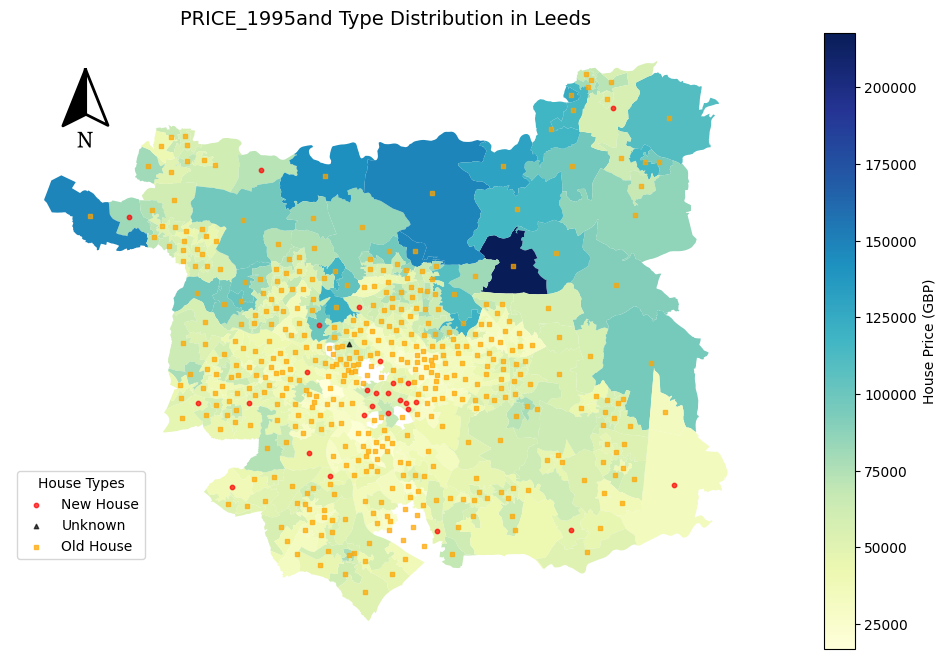

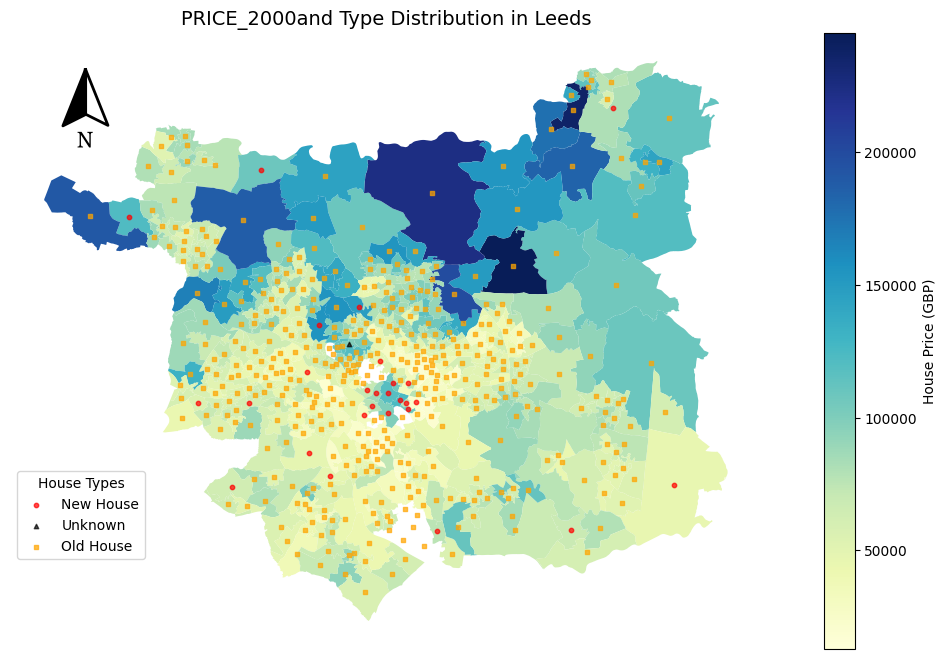

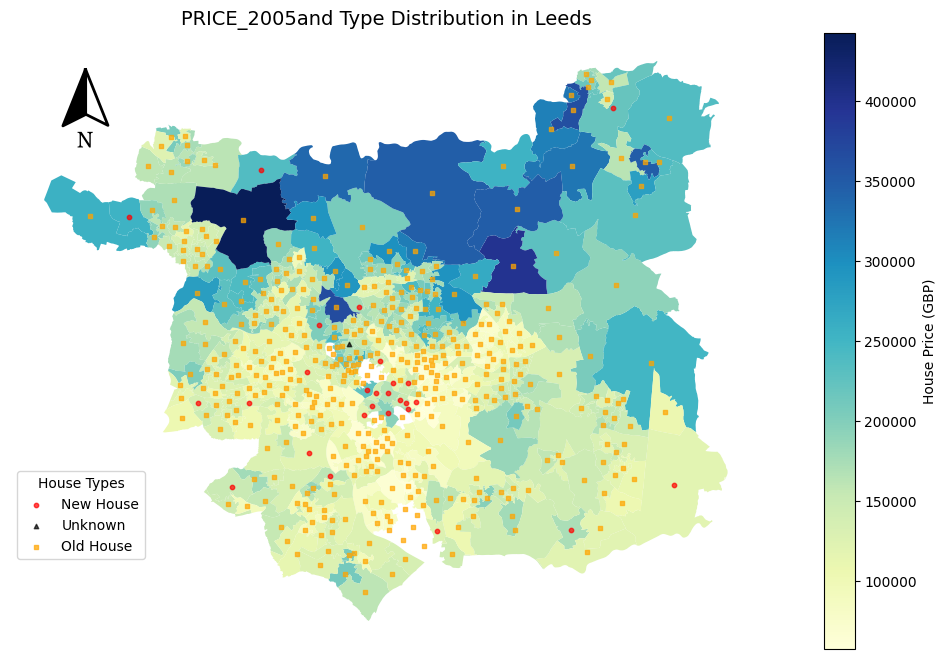

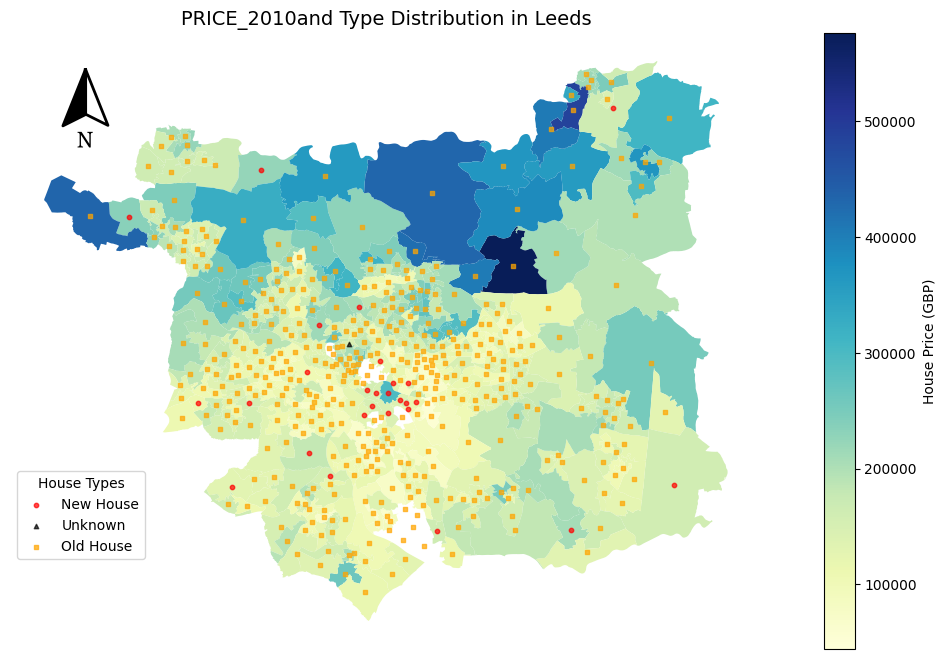

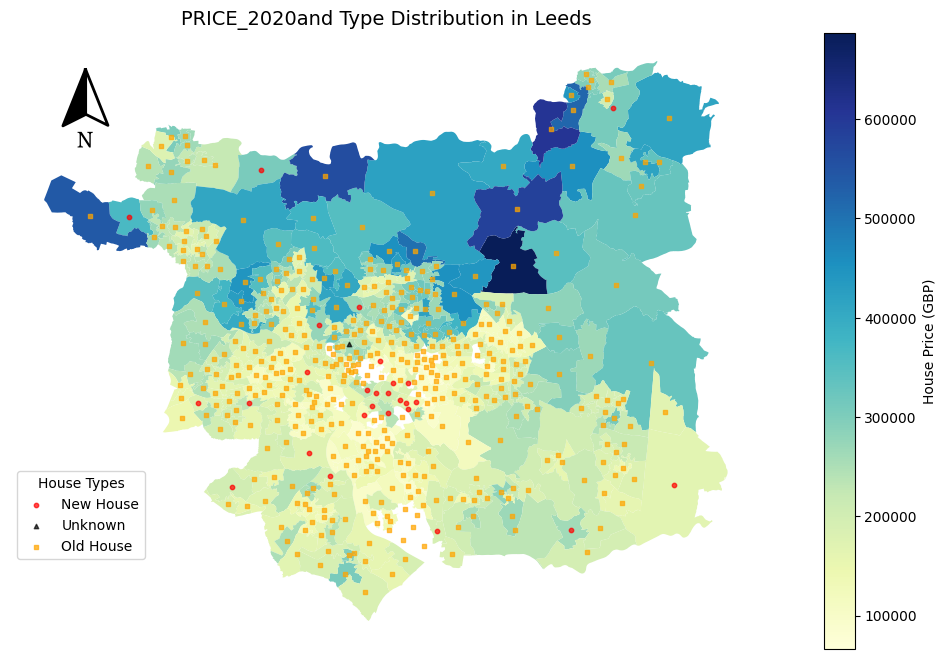

In [19]:
# 1. 房价字段列表
price_cols = ['price_1995', 'price_2000', 'price_2005', 'price_2010', 'price_2015', 'price_2020']

# 批量绘图
for col in price_cols:
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # 绘制房价地图
    df_final.plot(
        column=col,
        cmap='YlGnBu',
        linewidth=0.2,
        legend=True,
        ax=ax,
        legend_kwds={'label': 'House Price (GBP)', 'orientation': 'vertical'}
    )

    # 创建符号映射
    symbol_map = {
        "New House": "o",  # 新房 - 圆形
        "Unknown": "^",    # 未知 - 三角形
        "Old House": "s"   # 老房 - 方形
    }

    color_map = {
        "New House": 'red',  # 绿色
        "Unknown": "black",     # 灰色
        "Old House": "orange"     # 红色
    }

    # 在房价地图上叠加房屋类型符号
    for House_Type, marker in symbol_map.items():
        subset = df_final[df_final['House_Type'] == House_Type]  # 假设你已经根据房屋类型过滤了数据
        ax.scatter(subset.geometry.centroid.x, subset.geometry.centroid.y,
                   marker=marker, label=House_Type, alpha=0.7, color=color_map[House_Type], s=10)

    # 设置标题
    ax.set_title(f'{col.upper()}and Type Distribution in Leeds', fontsize=14)
    # Add a north arrow to the map, adjust its position and scale (for documentation, see: https://github.com/pmdscully/geo_northarrow)
    add_north_arrow(ax=ax, scale=0.75, xlim_pos=0.1, ylim_pos=0.85, color='#000', text_scaler=2, text_yT=-1.25)
    # 隐藏坐标轴
    ax.axis('off')
    # 添加图例
    ax.legend(title="House Types", bbox_to_anchor=(0, 0.3), loc="upper left")
    # 保存图像
    plt.savefig(f'{col}_leeds_map_with_symbols.jpg', bbox_inches='tight')
    #plt.close()

Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

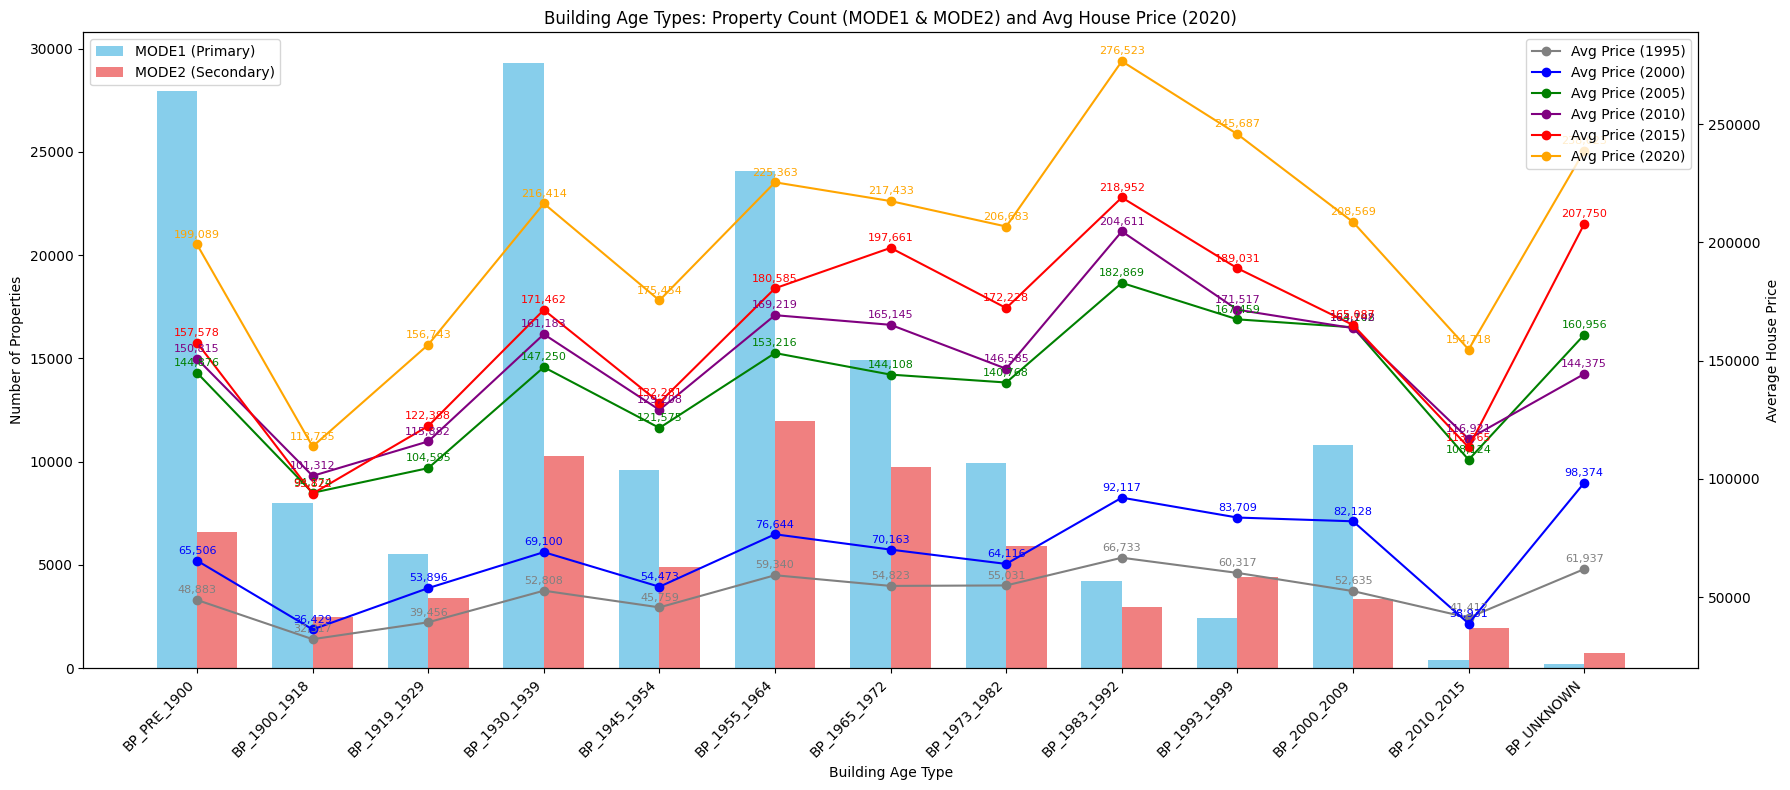

In [27]:
# X轴的位置
x = np.arange(len(combined_stats))
width = 0.35  # 设置柱宽

fig, ax1 = plt.subplots(figsize=(18, 8))

# 绘制柱状图
bar1 = ax1.bar(x - width/2, combined_stats['total_properties_mode1'], width, label='MODE1 (Primary)', color='skyblue')
bar2 = ax1.bar(x + width/2, combined_stats['total_properties_mode2'], width, label='MODE2 (Secondary)', color='lightcoral')

ax1.set_xlabel('Building Age Type')
ax1.set_ylabel('Number of Properties')
ax1.set_xticks(x)
ax1.set_xticklabels(combined_stats['Building_Age_Type'], rotation=45, ha='right')
ax1.legend(loc='upper left')

# 创建第二个 y 轴，绘制六个年份的房价曲线
ax2 = ax1.twinx()
ax2.set_ylabel('Average House Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 定义颜色字典和年份列表
year_colors = {
    '1995': 'gray',
    '2000': 'blue',
    '2005': 'green',
    '2010': 'purple',
    '2015': 'red',
    '2020': 'orange'
}
years = ['1995', '2000', '2005', '2010', '2015', '2020']

# 绘制每一条曲线并添加数值标签
for year in years:
    price_col = f'avg_price_{year}'
    color = year_colors[year]
    ax2.plot(x, combined_stats[price_col], marker='o', label=f'Avg Price ({year})', color=color)
    # 添加数值标签
    for i, price in enumerate(combined_stats[price_col]):
        ax2.text(x[i], price + 2000, f'{int(price):,}', ha='center', va='bottom', fontsize=8, color=color)

# 添加图例（放在右上角或其他合适位置）
ax2.legend(loc='upper right')



# 标题
plt.title('Building Age Types: Property Count (MODE1 & MODE2) and Avg House Price (2020)')
fig.tight_layout()
plt.show()

## References
<p><a href="add_url_here">[1]</a>Footnote citation goes here</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5990">[2]</a>GEOG5990M course materials</p>
<p><a href="add_url_here">[3]</a>Citation 3</p>